<a href="https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/blue_noise_optimize_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax.numpy as jnp
import numpy as np
import jax
import matplotlib.pyplot as plt

In [ ]:
def spectrum(m):
  # Put the constant term in the center
  return jnp.abs(jnp.fft.fftshift(jnp.fft.fft2(m)))

def blue_noise_loss(m, SIZE):
  # squared deviation from low frequency in the center
  CUTOFF_FREQ = 0.7
  low_freq_weights = jnp.maximum(CUTOFF_FREQ -jnp.outer(jnp.square(np.linspace(1,-1,SIZE)),jnp.ones(SIZE))-jnp.outer(np.ones(SIZE), jnp.square(jnp.linspace(1,-1,SIZE))), 0.0) / CUTOFF_FREQ
  return jnp.sum(low_freq_weights * low_freq_weights * jnp.square(spectrum(m))) / (SIZE*SIZE)

def histogram_loss(m, SIZE):
  # squared difference of sorted values as compared to the reference distribution
  reference_range = jnp.linspace(-1, 1, SIZE*SIZE)
  return jnp.sum(jnp.square(jnp.sort(m.flatten()) - reference_range))

def spectrum_uniformity_loss(m, SIZE):
  # a 2d laplacian as well as a sumple squared horizontal and vertical gradient
  s = spectrum(m)
  laplacian = (-4.0 * s + jnp.roll(s, 1, axis=1) + jnp.roll(s, -1, axis=1) + jnp.roll(s, 1, axis=0) + jnp.roll(s, -1, axis=0))/5.0
  g_x = (s - jnp.roll(s, 1, axis=0)) / 2.0
  g_y = (s - jnp.roll(s, 1, axis=1)) / 2.0
  return (jnp.sum(jnp.square(laplacian)) + jnp.sum(jnp.square(g_x)) + jnp.sum(jnp.square(g_y))) / (SIZE*SIZE)

def full_loss(m, loss_component_1 = 1.0, loss_component_2 = 1.0, loss_component_3 = 1.0):
  spectral_loss = blue_noise_loss(m, SIZE) * loss_component_3
  range_loss = histogram_loss(m, SIZE) * loss_component_2
  uniformity_loss = spectrum_uniformity_loss(m, SIZE) * loss_component_1
  return 0.01 * uniformity_loss + 2.2 * range_loss + 0.1 * spectral_loss

grad = jax.jit(jax.grad(full_loss))
loss = jax.jit(full_loss)


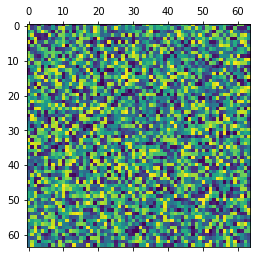

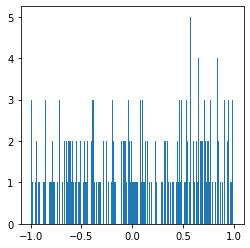

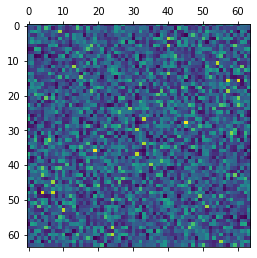

5.505376 1.7801368 1.7801368 32.367554
5.0340204 5.272999 5.272999 32.765087 0.0
0.06305511 0.0040078796 0.0040078796 0.12329376 5.0
0.058838375 0.0019543841 0.0019543841 0.10008027 10.0
0.05504856 7.145969e-05 7.145969e-05 0.086568296 15.0
0.052931756 0.00017119883 0.00017119883 0.080458745 20.0
0.052661188 0.00026227813 0.00026227813 0.07724741 25.0
0.051434185 1.2856137e-05 1.2856137e-05 0.073588766 30.0
0.050618086 2.2578322e-05 2.2578322e-05 0.07136528 35.0
0.0496339 8.835987e-05 8.835987e-05 0.06941189 40.0
0.048797958 0.000173967 0.000173967 0.067781635 45.0
0.048221827 0.00010280971 0.00010280971 0.06652266 50.0
0.04782587 4.2899894e-05 4.2899894e-05 0.065098576 55.00000000000001
0.04763145 2.8860828e-05 2.8860828e-05 0.06434658 60.0
0.047157124 0.0001460187 0.0001460187 0.062720045 65.0
0.047028594 0.00039938794 0.00039938794 0.06192044 70.0
0.04685249 3.1465137e-05 3.1465137e-05 0.061040863 75.0
0.046275225 2.21429e-05 2.21429e-05 0.05986012 80.0
0.04622954 0.0002989062 0.000

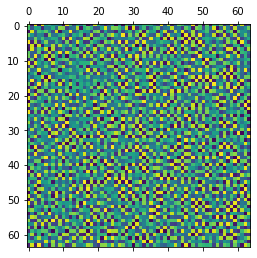

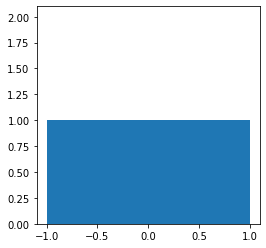

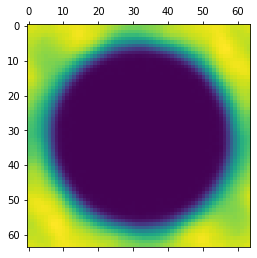

In [45]:
SIZE=64
noise_mat = jnp.array((np.random.rand(SIZE,SIZE) - 0.5) * 2.0, dtype='float32')
noise_orig = noise_mat.copy()

def plot_results(m, SIZE):
  plt.rcParams['figure.figsize']=4,4
  plt.matshow(m)
  plt.show()
  plt.hist(m.flatten(), bins=SIZE*SIZE)
  plt.show()
  plt.matshow(jnp.abs(jnp.fft.fftshift(jnp.fft.fft2(m))))
  plt.show()
plot_results(noise_mat, SIZE)
print(loss(noise_mat, 1.0, 0.0, 0.0), loss(noise_mat, 0.0, 1.0, 0.0), loss(noise_mat, 0.0, 1.0, 0.0), loss(noise_mat, 1.0, 1.0, 1.0))

N_ITER = 100000
for i in range(N_ITER):
  # Randomize the loss components relative weights and "stochasticize" it.
  grads = grad(noise_mat, np.random.rand(), np.random.rand(), np.random.rand())
  noise_mat = noise_mat - 0.7 * grads
  # Once every 5k iterations, print the loss for verification.
  if i % 5000 == 0:
    print(loss(noise_mat, 1.0, 0.0, 0.0), loss(noise_mat, 0.0, 1.0, 0.0), loss(noise_mat, 0.0, 1.0, 0.0), loss(noise_mat, 1.0, 1.0, 1.0), i / N_ITER * 100.0)
print(loss(noise_mat, 1.0, 0.0, 0.0), loss(noise_mat, 0.0, 1.0, 0.0), loss(noise_mat, 0.0, 1.0, 0.0), loss(noise_mat, 1.0, 1.0, 1.0))
# fine tune the histogram
for i in range(10):
  grads = grad(noise_mat, 0.0, np.random.rand(), 0.0)
  noise_mat = noise_mat - 0.1 * grads
plot_results(noise_mat, SIZE)

In [ ]:
import cv2
import scipy.ndimage
import urllib.request

# Get the test image.
urllib.request.urlretrieve('https://www.dropbox.com/s/11rd44q5kdgdqki/kodim14.png?dl=1', filename='kodim14.png')
test_img = cv2.imread('kodim14.png')[:,:,(2,1,0)] / 255.0


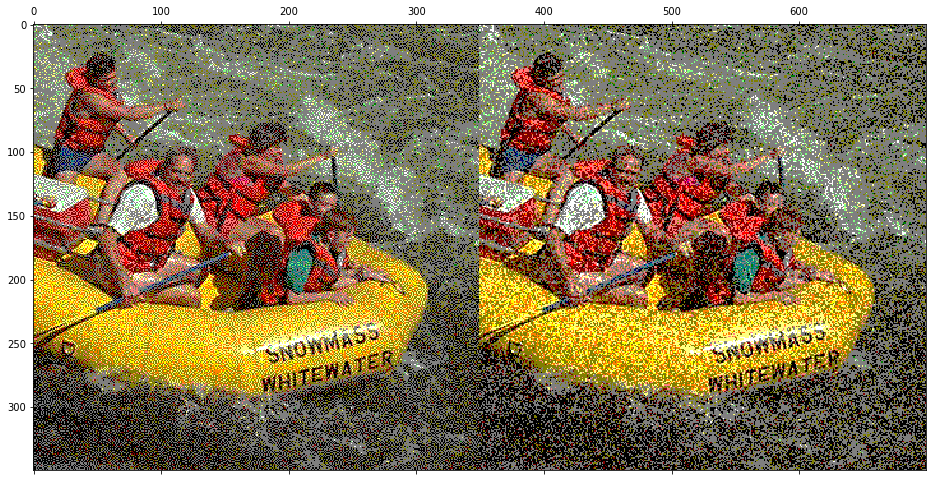

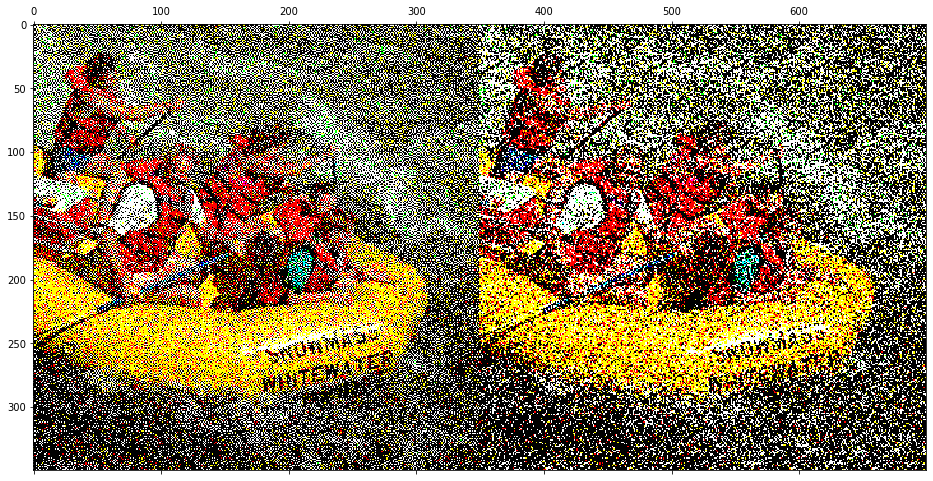

In [46]:
noise_wrapped = jnp.tile(noise_mat, reps=[10,10])[0:test_img.shape[0], 0:test_img.shape[1]]
noise_wrapped_3d = jnp.stack((noise_wrapped,noise_wrapped,noise_wrapped), axis=-1)
noise_wrapped_orig = jnp.tile(noise_orig, reps=[10,10])[0:test_img.shape[0], 0:test_img.shape[1]]
noise_wrapped_orig_3d = jnp.stack((noise_wrapped_orig,noise_wrapped_orig,noise_wrapped_orig), axis=-1)

plt.rcParams['figure.figsize']=15,15

# 2 bits
dither_scale = 2.0
dithered_blue = 1.0/dither_scale*np.round(dither_scale*test_img+0.5*noise_wrapped_3d)
dithered_white = 1.0/dither_scale*np.round(dither_scale*test_img+0.5*noise_wrapped_orig_3d)

plt.matshow(np.hstack((dithered_blue, dithered_white)))
plt.show()

# 1 bit
dither_scale = 1.0
dithered_blue = 1.0/dither_scale*np.round(dither_scale*test_img+0.5*noise_wrapped_3d)
dithered_white = 1.0/dither_scale*np.round(dither_scale*test_img+0.5*noise_wrapped_orig_3d)

plt.matshow(np.hstack((dithered_blue, dithered_white)))
plt.show()
